# Get images from Kaggle

## Install Kaggle API client

In [1]:
%%bash
pip install kaggle

  Running setup.py bdist_wheel for kaggle: started
  Running setup.py bdist_wheel for kaggle: finished with status 'done'
  Stored in directory: /home/ec2-user/.cache/pip/wheels/ee/97/c5/87dcdc9434fe4e632ed5945e31a03703af229db178ef6a00e8
  Running setup.py bdist_wheel for python-slugify: started
  Running setup.py bdist_wheel for python-slugify: finished with status 'done'
  Stored in directory: /home/ec2-user/.cache/pip/wheels/16/7f/c3/6b0582283ad589d68a306da924a78c74546e010d8106b9b3a9
Successfully built kaggle python-slugify


You are using pip version 10.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Move API key to where Kaggle expects it and change file permissions

In [2]:
%%bash

mkdir /home/ec2-user/.kaggle/
mv /home/ec2-user/SageMaker/kaggle.json /home/ec2-user/.kaggle/
chmod 600 /home/ec2-user/.kaggle/kaggle.json

In [3]:
%%bash

kaggle datasets list --user paultimothymooney

ref                                                          title                                               size  lastUpdated          downloadCount  
-----------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
paultimothymooney/denver-crime-data                          Denver Crime Data                                   88MB  2019-05-24 03:12:08           1810  
paultimothymooney/police-pedestrian-stops-and-vehicle-stops  Denver Police Pedestrian Stops and Vehicle Stops    68MB  2019-05-24 03:12:07            254  
paultimothymooney/chest-xray-pneumonia                       Chest X-Ray Images (Pneumonia)                       1GB  2018-03-24 19:41:59          11783  
paultimothymooney/mueller-report                             The Mueller Report                                 124MB  2019-04-20 20:21:27            318  
paultimothymooney/chiu-2015                                  Seg

## Download the breast cancer detection dataset

In [4]:
%%bash

kaggle datasets download --unzip paultimothymooney/breast-histopathology-images

100%|██████████| 1.49G/1.49G [00:16<00:00, 98.1MB/s]


## Unzip the dataset to the images directory and remove the original ZIP file

In [5]:
%%bash

unzip IDC_regular_ps50_idx5.zip -d images
rm -rf IDC_regular_ps50_idx5.zip

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Reorganize files in the images directory into two subdirectories, corresponding to the two classes we have (0 and 1). This will be useful when converting images to RecordIO format

In [6]:
%%bash

mkdir images/0
mkdir images/1

In [8]:
import os

In [9]:
for path, subdirs, files in os.walk('images'):
    for name in files:
        filename = os.path.join(path, name)
        if name.endswith('class0.png'):
            destination_class = '0'
        else:
            destination_class = '1'
        os.rename(filename, os.path.join('images', destination_class, name))

In [10]:
%%bash
shopt -s extglob
cd images
rm -rf !("0"|"1")

# Explore the images

## Count the number of images for each class

In [8]:
%%bash
cd images/0
ls -1 | wc -l

198738


In [9]:
%%bash
cd images/1
ls -1 | wc -l

78786


## Show an image with no cancer (class 0)

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

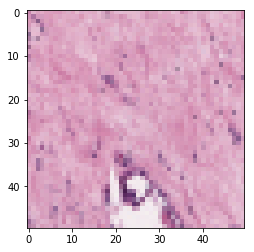

In [2]:
img = mpimg.imread('images/0/8975_idx5_x2851_y1201_class0.png')
imgplot = plt.imshow(img)
plt.show()

## Show an image with cancer (class 1)

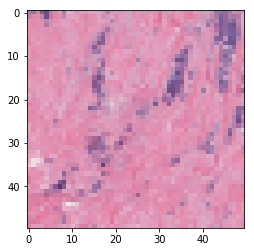

In [3]:
img = mpimg.imread('images/1/9075_idx5_x801_y801_class1.png')
imgplot = plt.imshow(img)
plt.show()

# Convert images to the RecordIO format and upload to S3

## Get the im2rec script from Apache MXNet Github repository

In [4]:
%%bash

wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
chmod +x im2rec.py

--2019-05-24 18:48:46--  https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15838 (15K) [text/plain]
Saving to: ‘im2rec.py’

     0K .......... .....                                      100% 16.7M=0.001s

2019-05-24 18:48:46 (16.7 MB/s) - ‘im2rec.py’ saved [15838/15838]



## Create the .lst files needed for creating the .rec files for train and test datasets

In [5]:
%%bash

python im2rec.py --list --recursive --test-ratio 0.3 --train-ratio 0.7 images images/

0 0
1 1


## Create the .rec files for train and test datasets

In [6]:
%%bash

python im2rec.py --num-thread 4 --pass-through images_train.lst images
python im2rec.py --num-thread 4 --pass-through images_test.lst images

Creating .rec file from /home/ec2-user/SageMaker/images_train.lst in /home/ec2-user/SageMaker
time: 0.0007662773132324219  count: 0
time: 0.19082427024841309  count: 1000
time: 0.181488037109375  count: 2000
time: 0.1707146167755127  count: 3000
time: 0.17119812965393066  count: 4000
time: 0.17626166343688965  count: 5000
time: 0.1829833984375  count: 6000
time: 0.27887463569641113  count: 7000
time: 0.3307371139526367  count: 8000
time: 0.33389925956726074  count: 9000
time: 0.32243919372558594  count: 10000
time: 0.37558722496032715  count: 11000
time: 0.3228487968444824  count: 12000
time: 0.32256054878234863  count: 13000
time: 0.31105899810791016  count: 14000
time: 0.3321256637573242  count: 15000
time: 0.32652997970581055  count: 16000
time: 0.3286905288696289  count: 17000
time: 0.3238065242767334  count: 18000
time: 0.3290855884552002  count: 19000
time: 0.32583165168762207  count: 20000
time: 0.32876014709472656  count: 21000
time: 0.3682377338409424  count: 22000
time: 0.331

## Uploading the train and test .rec files to S3

In [7]:
%%bash

aws s3 cp images_train.rec s3://sagemaker-data-jv/breast-cancer-detection/input/recordio/train/
aws s3 cp images_test.rec s3://sagemaker-data-jv/breast-cancer-detection/input/recordio/test/

upload: ./images_train.rec to s3://sagemaker-data-jv/breast-cancer-detection/input/recordio/train/images_train.rec
upload: ./images_test.rec to s3://sagemaker-data-jv/breast-cancer-detection/input/recordio/test/images_test.rec
